<a href="https://colab.research.google.com/github/happylittle7/TAICA_Generative-AI-Text-and-Image-Synthesis-Principles-and-Practice/blob/main/NTNU_41247032S_%E8%B3%87%E5%B7%A5116_%E5%90%B3%E4%BF%8A%E5%BB%B7_HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 實作RAG系統

一樣先下載這次會用到的相關基本套件

In [1]:
%matplotlib inline

!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr



下載我們事前準備的資料，這次資料我收集了師大2024-2025的相關pdf校務會議記錄，原始檔案可以在[這邊下載](https://scr.ntnu.edu.tw/school-meeting.htm)

In [6]:
!wget -O faiss_db.zip 'https://drive.google.com/uc?export=download&id=1epqTDLX3Ix7BmsikaVBb4-NQMhnwqd0h'
!unzip faiss_db.zip

--2025-06-03 15:21:22--  https://drive.google.com/uc?export=download&id=1epqTDLX3Ix7BmsikaVBb4-NQMhnwqd0h
Resolving drive.google.com (drive.google.com)... 172.253.62.139, 172.253.62.101, 172.253.62.100, ...
Connecting to drive.google.com (drive.google.com)|172.253.62.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1epqTDLX3Ix7BmsikaVBb4-NQMhnwqd0h&export=download [following]
--2025-06-03 15:21:22--  https://drive.usercontent.google.com/download?id=1epqTDLX3Ix7BmsikaVBb4-NQMhnwqd0h&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.179.132, 2607:f8b0:4004:c1f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.179.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1550935 (1.5M) [application/octet-stream]
Saving to: ‘faiss_db.zip’

faiss_db.zip        100%[===================>]   1.48M  --.-KB/s

引入這次RAG實作相關的套件

In [7]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

接著我們要自訂E5 Embedding格式

In [8]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

接著將我們的資料導入，並且套用剛剛設定的自訂E5 Embedding格式

In [9]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

接下來跟之前的對話機器人作業一樣，我們要設定API。因為ollama每次都要下載模型，而且模型大小又不能太大不然要等很久，所以這次我打算直接用Groq，並且使用最新的llama4模型

記得要先去設定API Key

In [10]:
import os
from google.colab import userdata
from openai import OpenAI

api_key = userdata.get("Groq")
os.environ["OPENAI_API_KEY"] = api_key

base_url = "https://api.groq.com/openai/v1"
model = "meta-llama/llama-4-scout-17b-16e-instruct"

client = OpenAI(
    base_url=base_url,
)

接著我們來設定Prompt

我打算打造一個師大校務會議智慧秘書，他能根據過往的會議記錄回答使用者的相關問題

In [11]:
system_prompt = """
你是國立台灣師範大學的校務會議智慧秘書，請根據資料來回應使用者的問題。
你的任務是解答有關使用者對於過去師大校務會議記錄的所有問題。
請以親切、專業的態度協助使用者。
"""

prompt_template = """
以下是最近有關師大校務會議的相關會議記錄，請根據資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

嚴格使用臺灣習慣的繁體中文語氣回答。
若資料不足以回答使用者，請告訴使用者可以上師大秘書室官網查詢更多資料。
"""


把參數丟到韓式裡面設定好

In [12]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

接著設定Gradio，接下來就可以開啟Gradio看看我們的成果了

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# 🎓 國立臺灣大學師範大學校務會議智慧秘書")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="請輸入你的問題...")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

<ipython-input-13-2a1f65c0da8f>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://58067ffb6fea64cfa2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<ipython-input-12-ef9176c6ed60>:6: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(user_input)


## 截圖

可以看到秘書可以根據最近幾筆會議記錄給出完整的回應，非常方便。感覺以後學校也可以做一個。

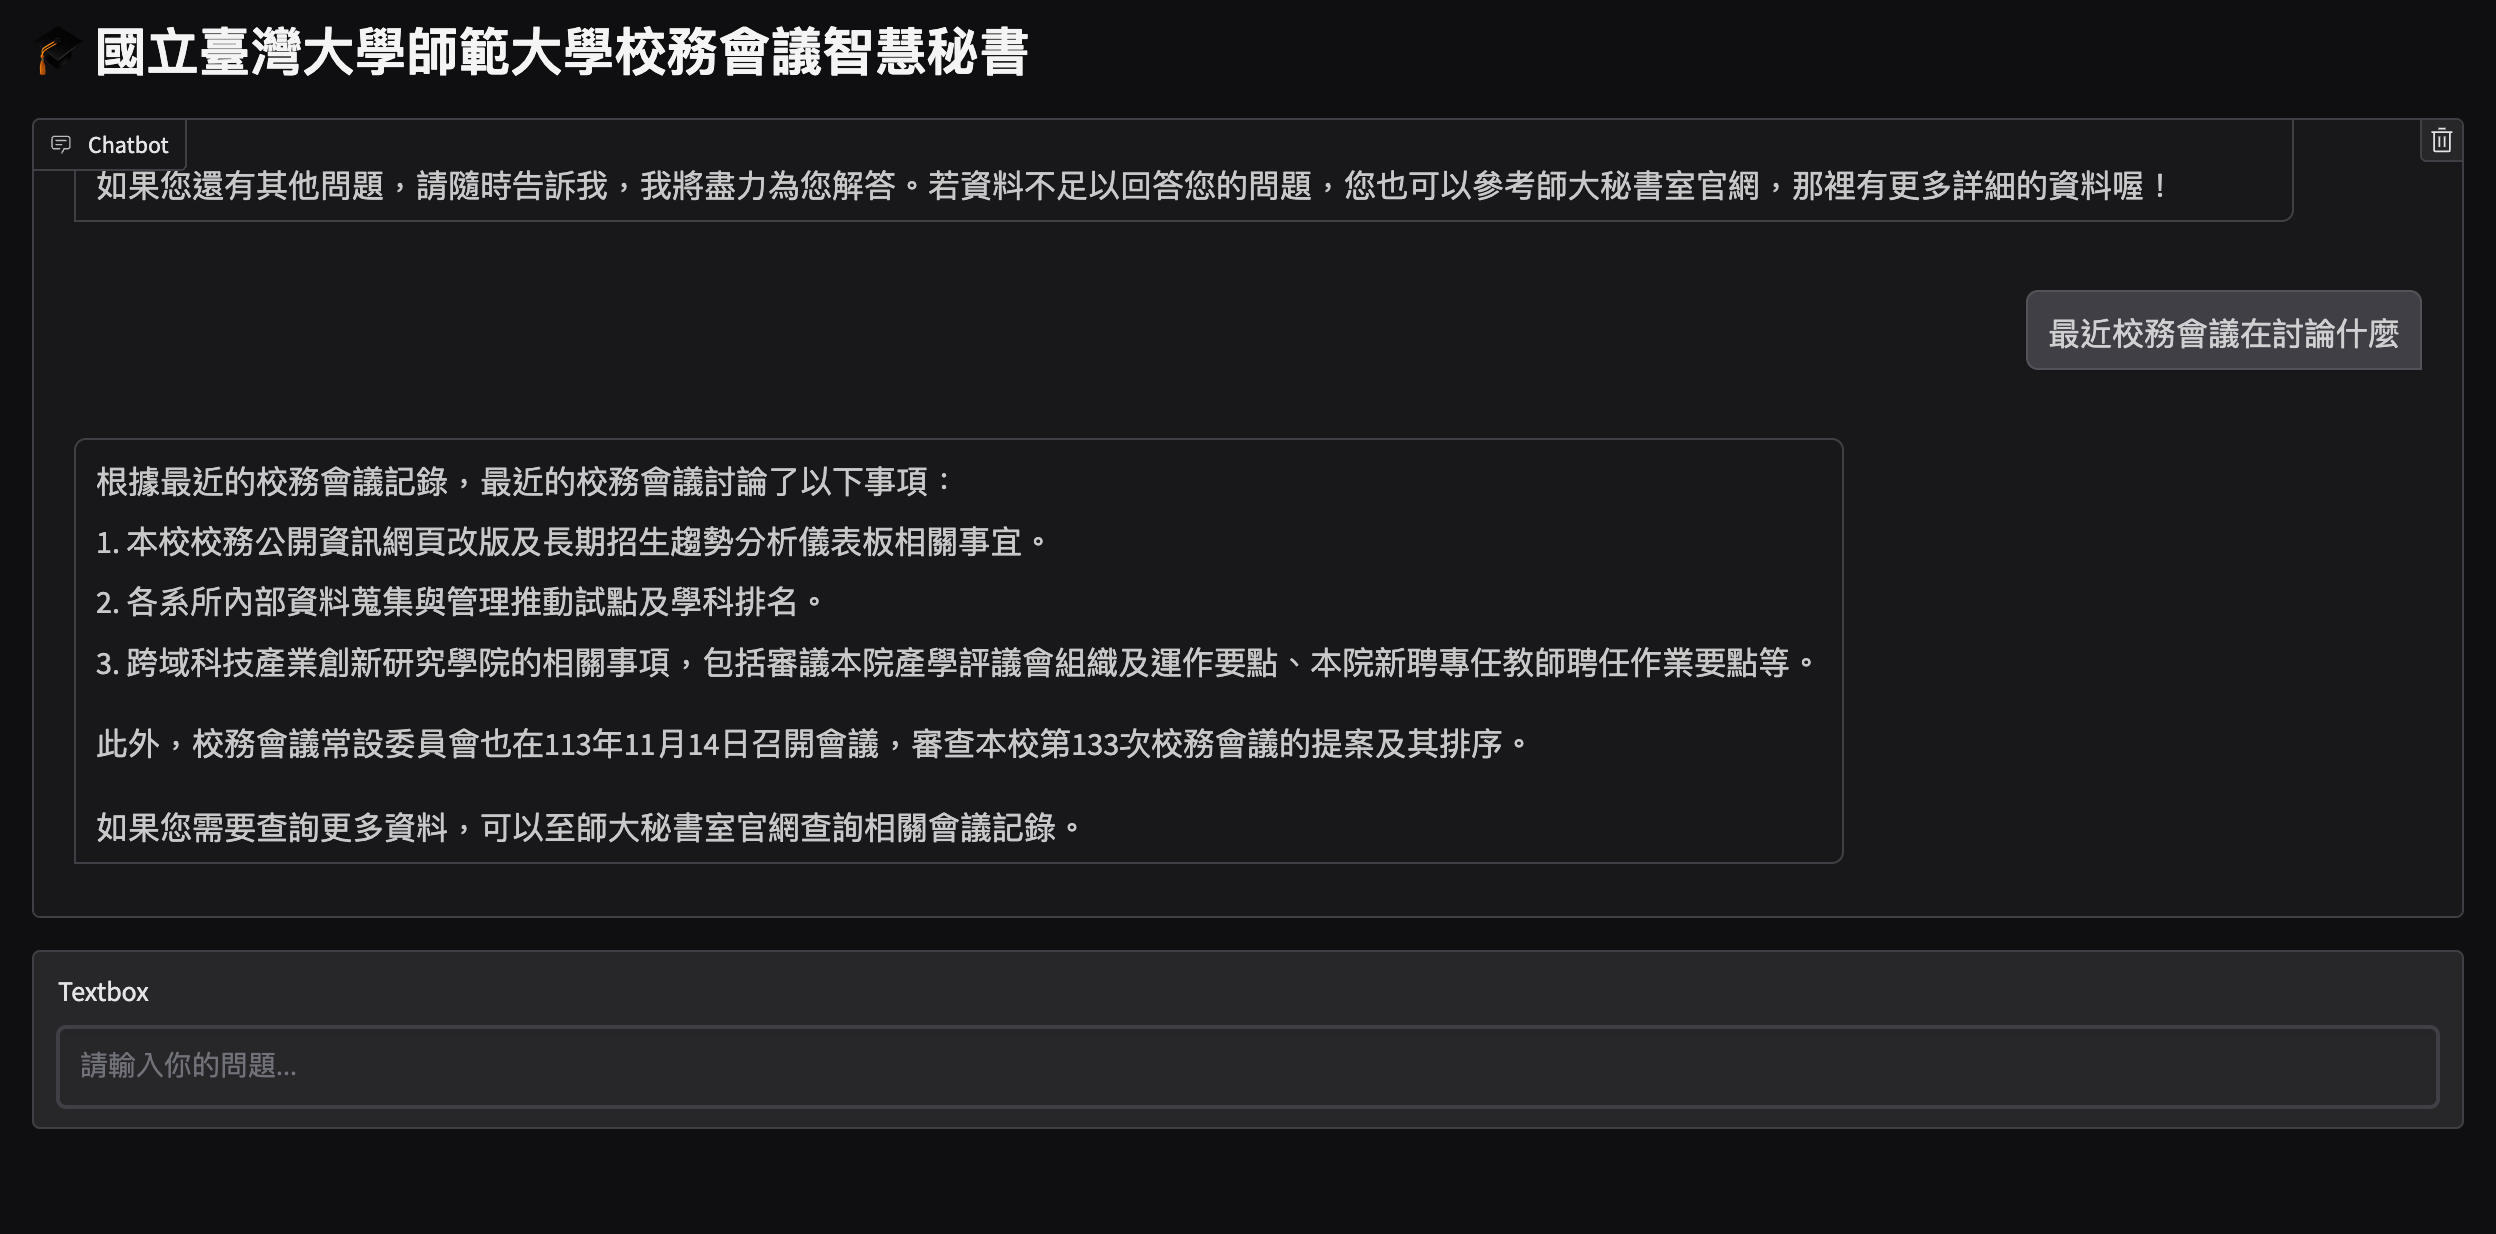